# PyTorch를 이용한 AutoEncoder 구현하기


> ## 1. PyTorch를 이용하여 FashionMNIST 데이터셋 로드하기
> ## 2. PyTorch를 이용한 모델 구성하기
> ## 3. PyTorch를 이용한 학습 Loop 구성하기
> ## 4. PyTorch를 이용하여 Inference 하기

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt # Matplotlib: 이미지 출력을 돕는 모듈
from matplotlib import cm # Data 포인트에 색상입히는 용도
import numpy as np # Numpy 행렬 변환


In [ ]:
# 하이퍼파라미터
EPOCH = 50
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [ ]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',   # 바지 정장
    2: 'Pullover',  # 스웨터
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 1. PyTorch를 이용하여 FashionMNIST 데이터셋 로드하기

In [ ]:
# Fashion MNIST 데이터셋 다운로드 및 데이터로더 선언
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

# 2. PyTorch를 이용한 모델 구성하기

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2),   # 입력의 특징을 2차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# PyTorch에서는 tensor나 model의 weight를 계산할 장치(device)를 명시해줘야 함
autoencoder = Autoencoder().to(DEVICE)

#최적화 함수 : Adam() --> SGD의 변형, 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 

# MSE(Mean Squared Error) : 평균 제곱 오차
criterion = nn.MSELoss()


In [ ]:
# 원본 이미지를 시각화 하기 (첫번째 열)

view_data = trainset.data[:5].view(-1, 28*28)
view_label = trainset.targets[:5].numpy()

view_data = view_data.type(torch.FloatTensor)/255.
print(view_label)


[9 0 0 3 0]


# 3. PyTorch를 이용한 학습 Loop 구성하기

In [ ]:
def train_one_epoch(autoencoder, train_loader):
    autoencoder.train()

    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = criterion(decoded, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

In [ ]:
for epoch in range(1, EPOCH+1):
    train_one_epoch(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(10, 4))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        a[0][i].set_title(CLASSES[view_label[i]])

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()


# 4. PyTorch를 이용하여 Inference 하기

In [ ]:
# 잠재변수를 플롯으로 시각화
autoencoder.eval()

view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

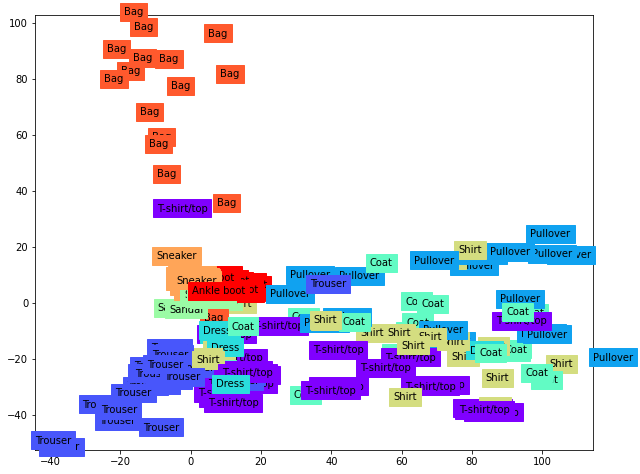

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,8))

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()

labels = trainset.targets[:200].numpy()

for x, y, s in zip(X, Y, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    plt.text(x, y, name, backgroundcolor=color)

plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.show()